# Training Convergence Plots for Learning Punctuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [2]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
ckpt_step = 8
batch_size = 512 #512 #4096
gpus=2
num_val_sys = 25
experiment = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False
single_system = True
zero_cut = False


compute_more_ckpts = False

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_25_1738272378.830401.pdf
quantiles 5 path exists?: True
ckpt_steps: [3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000, 36000, 39000, 42000, 45000, 48000, 51000, 54000, 57000, 60000, 63000, 66000, 69000, 72000, 75000, 78000, 81000, 84000, 87000, 90000, 93000, 96000, 99000, 102000, 105000, 108000, 111000, 114000, 117000, 120000, 123000, 126000, 129000, 132000, 135000, 138000, 141000, 144000, 147000, 150000, 153000, 156000, 159000, 162000, 165000, 168000, 171000, 174000, 177000, 180000]


i 0
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=141000.ckpt/single_system_gaussA_state_dim_10_err_lss.pkl
loaded Kalman_rem error
seg_starts_per_config: [[1, 126]]
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_g

findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


quantiles shape (60, 3)
no title for single system


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

(array([0.44806862, 2.4590025 , 6.803918  ], dtype=float32),
 [3072000,
  6144000,
  9216000,
  12288000,
  15360000,
  18432000,
  21504000,
  24576000,
  27648000,
  30720000,
  33792000,
  36864000,
  39936000,
  43008000,
  46080000,
  49152000,
  52224000,
  55296000,
  58368000,
  61440000,
  64512000,
  67584000,
  70656000,
  73728000,
  76800000,
  79872000,
  82944000,
  86016000,
  89088000,
  92160000,
  95232000,
  98304000,
  101376000,
  104448000,
  107520000,
  110592000,
  113664000,
  116736000,
  119808000,
  122880000,
  125952000,
  129024000,
  132096000,
  135168000,
  138240000,
  141312000,
  144384000,
  147456000,
  150528000,
  153600000,
  156672000,
  159744000,
  162816000,
  165888000,
  168960000,
  172032000,
  175104000,
  178176000,
  181248000,
  184320000])

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

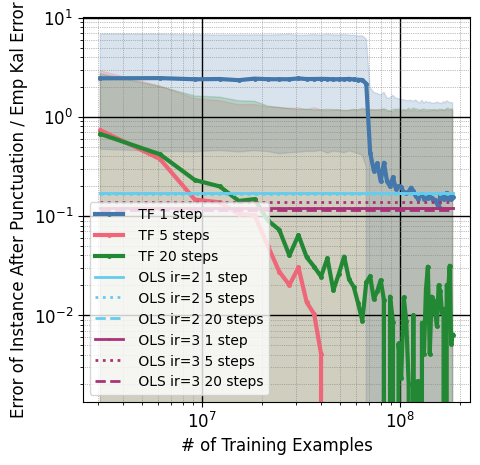

In [3]:
kal_ckpt = 141000 #60000 #81000 #28500
train_conv_plots([experiment], ["Identity"], [kal_ckpt], valA, valC, num_val_sys, compute_more_ckpts, None, 3000, 180000, 3000, state_dim, single_system=single_system, nope=nope, batch_size=batch_size, gpus=gpus, zero_cut=zero_cut)

# Zero Cut Plot

In [4]:
valA = "gaussA"
valC = "_gauss_C"
batch_size = 512 #512 #4096
gpus=1
num_val_sys = 25
experiment_zero_train = "250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
experiment_multi_train = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"
kal_ckpt_zero_train = 90000 
kal_ckpt_multi_train = 180000
datasource = "val"
state_dim = 10

In [10]:
kal_err_zero_train = get_other_err(valA, valC, kal_ckpt_zero_train, experiment_zero_train, "Kalman_rem", state_dim, zero_cut=True)

tf_err_zero_train, pred_ckpt = get_mop_ratios_ckpt(valA, valC, kal_ckpt_zero_train, experiment_zero_train, state_dim, zero_cut=True)

ols_irs = []
for ir in range(1, 4):
    ols_ir = get_other_err(valA, valC, kal_ckpt_zero_train, experiment_zero_train, f"OLS_ir_{ir}", state_dim, zero_cut=True)
    ols_irs.append(compute_ratio(None, ols_ir, kal_err_zero_train).cpu().numpy())

tf_err_rat_zero_train = compute_ratio(None, tf_err_zero_train, kal_err_zero_train)
tf_err_rat_zero_train = tf_err_rat_zero_train.cpu().numpy()
print("shape of tf_err_rat_zero_train: ", tf_err_rat_zero_train.shape)

/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
loaded Kalman_rem error
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
loaded OLS_ir_1 error
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_g

In [9]:
tf_err_multi_train, pred_ckpt = get_mop_ratios_ckpt(valA, valC, kal_ckpt_multi_train, experiment_multi_train, state_dim, zero_cut=True)

an_sim_err_multi_train = get_other_err(valA, valC, kal_ckpt_multi_train, experiment_multi_train, "Analytical_Simulation", state_dim, zero_cut=True)
an_sim_err_multi_train = compute_ratio(None, an_sim_err_multi_train, kal_err_zero_train).cpu().numpy()

# ols_irs = []
# for ir in range(1, 4):
#     ols_ir = get_other_err(valA, valC, kal_ckpt_multi_train, experiment_zero_train, f"OLS_ir_{ir}", state_dim, zero_cut=True)
#     ols_irs.append(compute_ratio(None, ols_ir, kal_err_zero_train).cpu().numpy())

tf_err_rat_multi_train = compute_ratio(None, tf_err_multi_train, kal_err_zero_train)
tf_err_rat_multi_train = tf_err_rat_multi_train.cpu().numpy()
print("shape of tf_err_rat_multi_train: ", tf_err_rat_multi_train.shape)

/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=180000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=180000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
loaded Analytical_Simulation error
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
shape of tf_err_rat_multi_train:  (3, 251)


In [12]:
tf_err_rat_zero_train -= 1
tf_err_rat_multi_train -= 1
for ir in range(3):
    ols_irs[ir] -= 1

findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

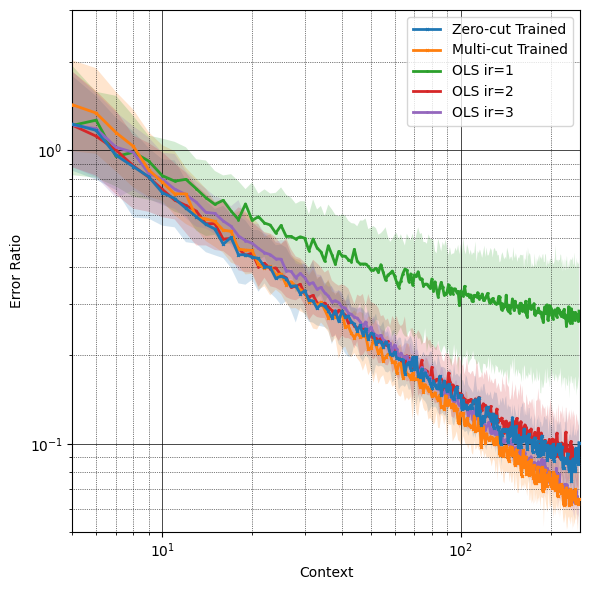

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
context_len = 251

ax.plot(np.arange(context_len), tf_err_rat_zero_train[1], label="Zero-cut Trained", linewidth=2, marker="x", markersize=2, zorder=5)#linestyle="--")
ax.fill_between(np.arange(context_len), tf_err_rat_zero_train[0], tf_err_rat_zero_train[2], alpha=0.2)

ax.plot(np.arange(context_len), tf_err_rat_multi_train[1], label="Multi-cut Trained", linewidth=2, marker="x", markersize=2, zorder=4)#, linestyle="-.")
ax.fill_between(np.arange(context_len), tf_err_rat_multi_train[0], tf_err_rat_multi_train[2], alpha=0.2)

# ax.plot(np.arange(context_len), an_sim_err_multi_train[1], label="Analytical Simulation", linewidth=2, marker=".", markersize=10)
# ax.fill_between(np.arange(context_len), an_sim_err_multi_train[0], an_sim_err_multi_train[2], alpha=0.15)

for ir in range(1, 4):
    ax.plot(np.arange(context_len), ols_irs[ir-1][1], label=f"OLS ir={ir}", linewidth=2, marker=".", markersize=2)
    ax.fill_between(np.arange(context_len), ols_irs[ir-1][0], ols_irs[ir-1][2], alpha=0.2)

ax.set_xlabel("Context")
ax.set_xlim([5, context_len])
ax.set_ylabel("Error Ratio")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.set_ylim([5e-2, 3e0])
plt.tight_layout()

plt.show()



## zero cut train conv

In [2]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
batch_size = 512 #512 #4096
gpus=2
num_val_sys = 25
experiment1 = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
experiment2 = "250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"
datasource = "val"
nope = False
single_system = False
zero_cut = True


compute_more_ckpts = True

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_25_1738272480.9015734.pdf
quantiles 5 path exists?: True
ckpt_steps: [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000, 101000, 102000, 103000, 104000, 105000, 106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000, 114000, 115000, 116000, 117000

findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.




i 1
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=90000.ckpt/zero_cut_gaussA_state_dim_10_err_lss.pkl
loaded Kalman_rem error
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=1000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
ratios shape after median: torch.Size([25, 251])
quantile shape: torch.Size([3])
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250127_001511.3ac954_multi_sys_trace_zero_cut_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=2000.ckpt/train_conv_zero_cut_gaussA_state_dim_10_err_lss.pkl
Loaded Transformer Errors
ratios shape: torch.Size([25, 2000, 251])
rati

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

quantiles shape (91, 3)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


(array([0.2527598 , 0.41225517, 0.5662619 ], dtype=float32),
 [3072000,
  6144000,
  9216000,
  12288000,
  15360000,
  18432000,
  21504000,
  24576000,
  27648000,
  30720000,
  33792000,
  36864000,
  39936000,
  43008000,
  46080000,
  49152000,
  52224000,
  55296000,
  58368000,
  61440000,
  64512000,
  67584000,
  70656000,
  73728000,
  76800000,
  79872000,
  82944000,
  86016000,
  89088000,
  92160000,
  95232000,
  98304000,
  101376000,
  104448000,
  107520000,
  110592000,
  113664000,
  116736000,
  119808000,
  122880000,
  125952000,
  129024000,
  132096000,
  135168000,
  138240000,
  141312000,
  144384000,
  147456000,
  150528000,
  153600000,
  156672000,
  159744000,
  162816000,
  165888000,
  168960000,
  172032000,
  175104000,
  178176000,
  181248000,
  184320000])

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

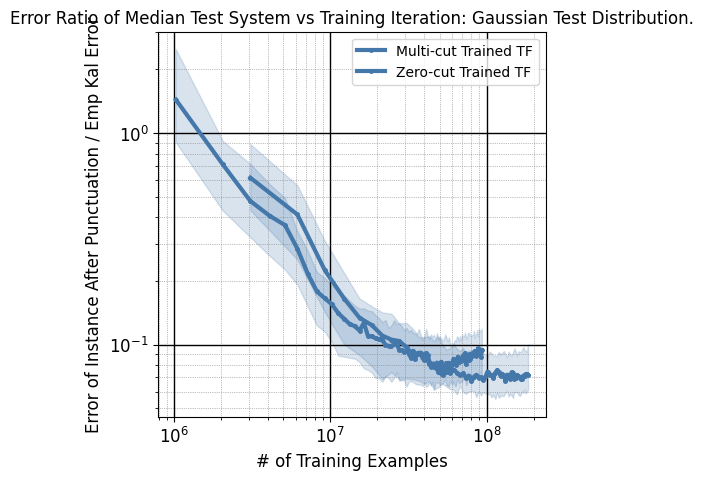

In [3]:
kal_ckpts = [180000, 90000]  #60000 #81000 #28500
train_conv_plots([experiment1, experiment2], ["Multi-cut Trained", "Zero-cut Trained"], kal_ckpts, valA, valC, num_val_sys, compute_more_ckpts, 200, 1000, 180000, 1000, state_dim, single_system=single_system, nope=nope, batch_size=batch_size, gpus=gpus, zero_cut=zero_cut)